# Degree Rips bifiltrations

**Note.** I'm not satisfied with this interface, so it may be subject to change.

In [1]:
import numpy as np
import gudhi as gd
import multipers as mp
import matplotlib.pyplot as plt

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


Let start with a noisy dataset, and let's try to recover some topological signal.

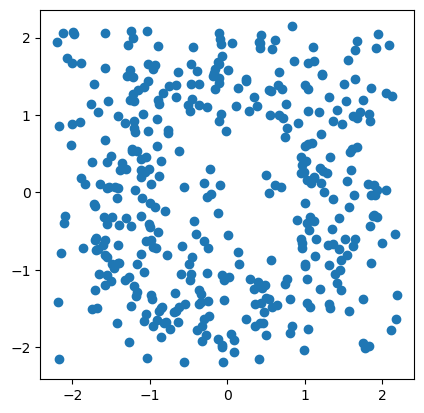

In [2]:
np.random.seed(0)
X = mp.data.noisy_annulus(200,200)
plt.scatter(*X.T);plt.gca().set_aspect(1)

## Definition

Now, if $\mathrm{Rips}_t(X)$ is the Viertoris-Rips filtration at scale $t\ge 0$, then 
$\mathrm{DegreeRips}(X)$ is a bifiltration over $\mathbb{R}_+\times \mathbb{N}^{\mathrm{op}}$, defined as follows:

$$\mathrm{DegreeRips}_{r,k}:= \left\{ \sigma \in \mathrm{Rips}_r \mid \forall x\in \sigma,\, \mathrm{degree}(\textnormal{1-skeleton}(\mathrm{Rips}_t(X)),x)\ge k\right\},$$

where given a graph $G$ and a node $n$, $\mathrm{degree}(G,n)$ is the degree of the node $n$ in $G$.

Note that this filtration is **not** 1-critical. See TODO for more details.

TODO : example.

In [3]:
# For computational reasons, we do not consider every possible degree
degrees = np.unique((np.linspace(0,50,51, dtype=int))) 
# The associated DegreeRips filtration can be encoded in a (multicritical) simplextree
st_multi = mp.filtrations.DegreeRips(points = X, ks=degrees,threshold_radius=1.5, squeeze=False)

This simplextree `st_multi` only holds the 1-skeleton of this bifiltration. It can be extended, as usual, to a higher dimension complex.

In [4]:
print(len(st_multi))
st_multi.expansion(2)
print(len(st_multi))
st_multi.prune_above_dimension(1)
print(len(st_multi))

23548
669199
23548


## First invariant computation

As shown above expanding simplextree without having access to edge collapse algorithms, or a similar preprocessing step, this is not tractable.

A simple strategy to compute invariants that only rely on 1-d slices is simply to lazy expand them once they are pushed forward on a line, and 1-d collapsed. This can be achieved using the `expand_collapse` flag in `mp.signed_measures`.

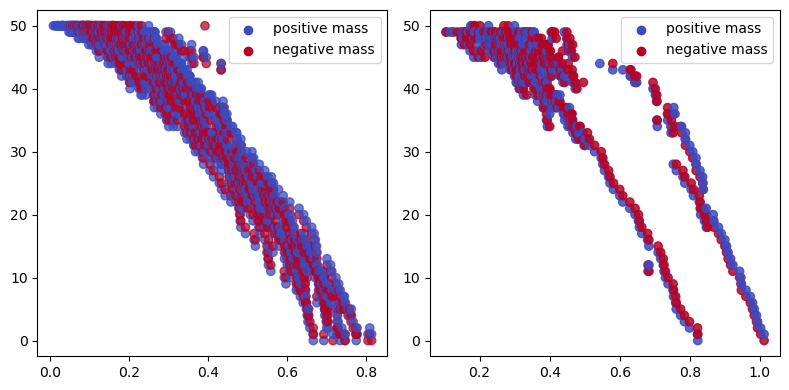

In [5]:
sm0,sm1 = mp.signed_measure(st_multi, degrees=[0,1], invariant="hilbert", plot=True, expand_collapse=True);

The hilbert signed measure encodes the hilbert function, from which we clearly see the 1-cycle here.

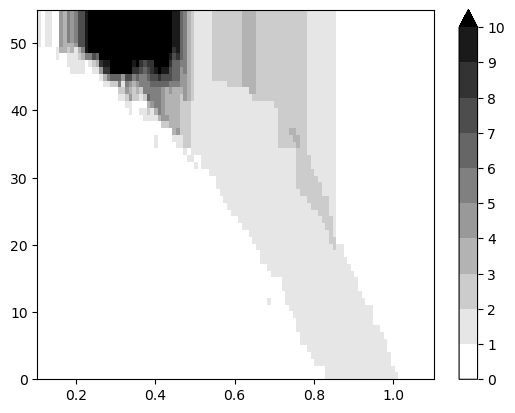

In [6]:
mp.point_measure.integrate_measure(*sm1, plot=True);

## Coarsenning strategies

Invariants that cannot use this strategy cannot be computed in a reasonable time without premilitary preprocessing (WIP) or filtration approximations. Degree 0 is not affected as it doesn't require any expansion.

MMA computations involving a geometric axis (here rips) can be computed more efficiently on the `[1,0]` direction (although the recovery guarantees change), with the second coordinate swapped (which, in this case, guarantees a "generic initialization").

/var/folders/w6/5k5w13s94bq0dfsx2xzqxcsh0000gn/T/ipykernel_73931/3727662367.py:2: UserWarning: Got a degenerate direction. This function may fail if the first line is not generic.
  mp.module_approximation(s, direction=[1,0], swap_box_coords=[1]).plot(0)


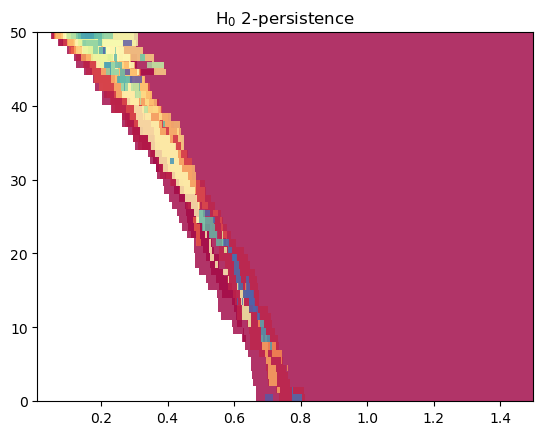

In [7]:
s = mp.Slicer(st_multi, vineyard=True, filtration_container="flat")
mp.module_approximation(s, direction=[1,0], swap_box_coords=[1]).plot(0)

A first strategy is to approximate the Rips itself, using, e.g., a sparse rips. Note that this is **not** backed up by theoretical guarantees.

In [8]:
# A custom complex (gudhi simplextree) can be put there instead.
st = gd.RipsComplex(points=X, sparse=.2, max_edge_length=1).create_simplex_tree()
st = mp.filtrations.DegreeRips(simplex_tree=st, degrees=np.linspace(0,100,100,dtype=int))

/Users/dlapous/micromamba/envs/313/lib/python3.13/site-packages/multipers/filtrations/filtrations.py:294: UserWarning: (copy warning) Had to copy the rips to infer the `degrees` or recover the 1st filtration parameter.
  warn(


In [9]:
st.expansion(2)
len(st)

112041

((array([[ 0.00000000e+00, -3.80000000e+01],
         [ 8.97183112e-03,  0.00000000e+00],
         [ 1.38429451e-02,  0.00000000e+00],
         ...,
         [ 9.47762083e-01, -3.80000000e+01],
         [ 9.65555104e-01, -3.90000000e+01],
         [ 9.65555104e-01, -3.80000000e+01]], shape=(3352, 2)),
  array([21,  2,  1, ...,  1, -1,  1], shape=(3352,), dtype=int32)),)

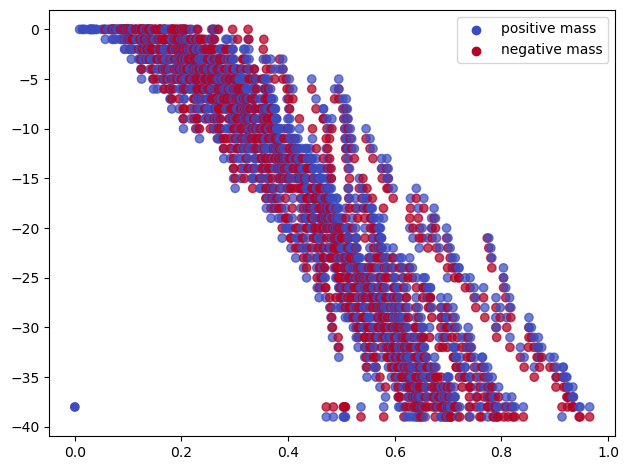

In [10]:
s = mp.Slicer(st, vineyard=False)
mp.signed_measure(s, degree=1, plot=True)

## TODOs to make it tractable

WIP